In [21]:
# Ensure repo root and 'src' are on sys.path for local imports
import sys
from pathlib import Path

# Attempt to locate repo root by searching upwards for 'src' folder
cwd = Path.cwd()
candidates = [
    cwd,
    cwd.parent,
    cwd.parent.parent,
    cwd.parent.parent.parent,
]
repo_root = None
for p in candidates:
    if (p / 'src').exists():
        repo_root = p
        break

if repo_root is None:
    # Fallback: assume notebook is at docs/research relative to repo
    repo_root = cwd.parent.parent

src_path = repo_root / 'src'
for p in (repo_root, src_path):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

print('Repo root detected:', repo_root)
print('Added to sys.path:', repo_root, 'and', src_path)

Repo root detected: c:\TNFR-Python-Engine
Added to sys.path: c:\TNFR-Python-Engine and c:\TNFR-Python-Engine\src


# TNFR Operator Sequences for Stable Molecules

Research notebook to explore whether canonical operator sequences (and their parameterizations) suffice to form stable molecular patterns under TNFR, and to discover sequence motifs that improve stability.

Goals:
- Build element-like patterns (TNFR-native) and couple them into molecules respecting U3 (resonant coupling).
- Evaluate stability using the Structural Field Tetrad metrics: Φ_s, |∇φ|, K_φ, ξ_C.
- Sweep coupling parameters and sequence templates to find stable configurations.
- Identify whether the 13 canonical operators are sufficient or if novel operator compositions are needed for complex behaviors.

References:
- Physics module: `src/tnfr/physics/` (patterns, signatures)
- Canonical grammar: `UNIFIED_GRAMMAR_RULES.md` (U1–U6)
- Molecular chemistry hub: `docs/MOLECULAR_CHEMISTRY_HUB.md`

In [3]:
# Setup imports and environment
import os, sys, math, json, random
from pathlib import Path

# Ensure repo root is importable
REPO_ROOT = Path.cwd()
if (REPO_ROOT / 'src').exists():
    sys.path.insert(0, str(REPO_ROOT))

import numpy as np
import networkx as nx

from src.tnfr.physics.patterns import build_element_radial_pattern
from src.tnfr.physics.signatures import compute_element_signature

print('Environment ready. Repo root:', REPO_ROOT)

Environment ready. Repo root: c:\TNFR-Python-Engine\docs\research


## Helper functions: phase coupling (U3), molecule builders, and measurement
We construct molecules by coupling element-like graphs via phase-compatible links (U3: |Δφ| ≤ Δφ_max).
We then evaluate stability via the signatures API (tetrad metrics).

In [4]:
def wrap_phase_diff(a, b):
    """Compute wrapped phase difference in [-pi, pi].
    Assumes phases are in radians in [0, 2*pi) or [-pi, pi).
    """
    d = (a - b + math.pi) % (2*math.pi) - math.pi
    return abs(d)

def couple_graphs_by_phase(G1, G2, delta_phi_max=0.4, max_links=8):
    """
    Combine two graphs into one and add up to `max_links` inter-graph edges
    connecting nodes whose phases satisfy U3 (|Δφ| ≤ delta_phi_max).
    This is a research coupling step honoring U3; it does not mutate EPI via operators.
    """
    # Disjoint union to keep node ids unique
    H = nx.disjoint_union(G1, G2)
    # Map original node ids to combined graph ids
    n1 = G1.number_of_nodes()
    nodes1 = list(range(n1))
    nodes2 = list(range(n1, H.number_of_nodes()))

    # Collect candidate pairs with smallest phase differences
    candidates = []
    for i in nodes1:
        th_i = H.nodes[i].get('theta', 0.0)
        for j in nodes2:
            th_j = H.nodes[j].get('theta', 0.0)
            dphi = wrap_phase_diff(th_i, th_j)
            if dphi <= delta_phi_max:
                candidates.append((dphi, i, j))
    candidates.sort(key=lambda t: t[0])

    # Add up to max_links best-phase edges
    links_added = 0
    for _, i, j in candidates:
        if links_added >= max_links:
            break
        # Avoid multi-edges in simple graph
        if not H.has_edge(i, j):
            H.add_edge(i, j)
            links_added += 1
    return H

def build_diatomic(Z1, Z2, seed=42, delta_phi_max=0.4, max_links=8):
    G1 = build_element_radial_pattern(Z1, seed=seed)
    G2 = build_element_radial_pattern(Z2, seed=seed+1)
    return couple_graphs_by_phase(G1, G2, delta_phi_max=delta_phi_max, max_links=max_links)

def build_linear_triatomic(Z_left, Z_center, Z_right, seed=42, delta_phi_max=0.4, max_links=8):
    # Build center with left, then couple with right
    left = build_element_radial_pattern(Z_left, seed=seed)
    center = build_element_radial_pattern(Z_center, seed=seed+1)
    right = build_element_radial_pattern(Z_right, seed=seed+2)
    tmp = couple_graphs_by_phase(left, center, delta_phi_max=delta_phi_max, max_links=max_links)
    H = couple_graphs_by_phase(tmp, right, delta_phi_max=delta_phi_max, max_links=max_links)
    return H

def measure_signature(G, apply_synthetic_step=True):
    sig = compute_element_signature(G, apply_synthetic_step=apply_synthetic_step)
    return sig

## Quick sanity checks: H₂, O₂, CO, and CO₂ (linear)

In [5]:
tests = {}
tests['H2'] = build_diatomic(1, 1, seed=101, delta_phi_max=0.5, max_links=6)
tests['O2'] = build_diatomic(8, 8, seed=102, delta_phi_max=0.45, max_links=8)
tests['CO'] = build_diatomic(6, 8, seed=103, delta_phi_max=0.4, max_links=8)
tests['CO2'] = build_linear_triatomic(8, 6, 8, seed=104, delta_phi_max=0.4, max_links=8)

for name, G in tests.items():
    sig = measure_signature(G, apply_synthetic_step=True)
    print(f'=== {name} ===')
    print('xi_c:', sig['xi_c'], 'class:', sig['signature_class'], 'grad:', round(sig['mean_phase_gradient'],3), 'curv_max:', round(sig['max_phase_curvature_abs'],3))

=== H2 ===
xi_c: 22.589897909194807 class: marginal grad: 1.484 curv_max: 3.133
=== O2 ===
xi_c: 26.817494738147374 class: marginal grad: 1.593 curv_max: 3.133
=== CO ===
xi_c: 26.389085094048276 class: marginal grad: 1.593 curv_max: 3.08
=== CO2 ===
xi_c: 94.13429013373825 class: marginal grad: 1.528 curv_max: 3.14


## Parameter sweep: find stable configurations
We sweep Δφ_max (U3 coupling tolerance), max_links, and seeds to identify stable or marginally stable molecules.

In [7]:
def sweep_diatomic(Z1, Z2, seeds=range(50,60), delta_phi_vals=(0.3,0.35,0.4,0.45,0.5), max_links_vals=(4,6,8), top_k=5):
    results = []
    for seed in seeds:
        for dphi in delta_phi_vals:
            for ml in max_links_vals:
                G = build_diatomic(Z1, Z2, seed=seed, delta_phi_max=dphi, max_links=ml)
                sig = measure_signature(G, apply_synthetic_step=True)
                results.append({
                    'Z': (Z1, Z2), 'seed': seed, 'delta_phi_max': dphi, 'max_links': ml,
                    **sig
                })
    # Sort by stability class then by low mean_phase_gradient and low max curvature
    def score(r):
        cls = {'stable':0, 'marginal':1, 'unstable':2}.get(r['signature_class'], 3)
        return (cls, r['mean_phase_gradient'], r['max_phase_curvature_abs'])
    results.sort(key=score)
    return results[:top_k], results

top5_H2, all_H2 = sweep_diatomic(1,1)
top5_CO, all_CO = sweep_diatomic(6,8)

print('Top H2 configs (best first):')
for r in top5_H2:
    print({k:r[k] for k in ['Z','seed','delta_phi_max','max_links','signature_class','mean_phase_gradient','max_phase_curvature_abs']})

print('Top CO configs (best first):')
for r in top5_CO:
    print({k:r[k] for k in ['Z','seed','delta_phi_max','max_links','signature_class','mean_phase_gradient','max_phase_curvature_abs']})

Top H2 configs (best first):
{'Z': (1, 1), 'seed': 51, 'delta_phi_max': 0.3, 'max_links': 8, 'signature_class': 'marginal', 'mean_phase_gradient': 1.2891302600690422, 'max_phase_curvature_abs': 2.6657852721808926}
{'Z': (1, 1), 'seed': 51, 'delta_phi_max': 0.35, 'max_links': 8, 'signature_class': 'marginal', 'mean_phase_gradient': 1.2891302600690422, 'max_phase_curvature_abs': 2.6657852721808926}
{'Z': (1, 1), 'seed': 51, 'delta_phi_max': 0.4, 'max_links': 8, 'signature_class': 'marginal', 'mean_phase_gradient': 1.2891302600690422, 'max_phase_curvature_abs': 2.6657852721808926}
{'Z': (1, 1), 'seed': 51, 'delta_phi_max': 0.45, 'max_links': 8, 'signature_class': 'marginal', 'mean_phase_gradient': 1.2891302600690422, 'max_phase_curvature_abs': 2.6657852721808926}
{'Z': (1, 1), 'seed': 51, 'delta_phi_max': 0.5, 'max_links': 8, 'signature_class': 'marginal', 'mean_phase_gradient': 1.2891302600690422, 'max_phase_curvature_abs': 2.6657852721808926}
Top CO configs (best first):
{'Z': (6, 8), '

## Sequence templates (symbolic) and grammar notes
We consider canonical sequence motifs and verify U1–U6 compliance conceptually.

Example motifs:
- Stabilize: [IL, SHA]
- Explore: [OZ, ZHIR, IL] (requires handlers per U4a, prior IL per U4b)
- Bond formation (conceptual): [OZ, ZHIR, UM, IL] with U3 phase verification before UM

Note: This notebook enforces U3 in coupling via Δφ_max. Future work can integrate direct operator application once a stable API for operator execution in notebooks is standardized in the engine.

In [8]:
# Optional: persist sweep results to JSONL for later analysis
out_dir = Path('docs/research/results')
out_dir.mkdir(parents=True, exist_ok=True)
with open(out_dir / 'molecular_sequences_sweep.jsonl', 'w', encoding='utf-8') as f:
    for r in (all_H2 + all_CO):
        f.write(json.dumps(r) + '\n')
print('Saved results to', out_dir / 'molecular_sequences_sweep.jsonl')

Saved results to docs\research\results\molecular_sequences_sweep.jsonl


## Executable sequence motifs (API-ready placeholder)

This section provides a thin adapter that will plug into a future notebook-friendly
operator API to run canonical sequences while enforcing U1–U6. For now it performs
only structural validations and stubs the execution step.

- Validates U3 (phase verification) before coupling actions
- Provides a `SequenceRunner` interface to integrate once operators are exposed
- Keeps telemetry read-only semantics for physics utilities

In [9]:
# SequenceRunner placeholder: validates U3 and stubs execution
from typing import List, Dict, Any, Optional

class SequenceRunner:
    """
    API-ready adapter to run operator sequences in notebooks once exposed.
    For now, provides:
    - U3 phase verification helpers
    - Grammar compliance notes (U1–U6) at submission time
    - Stub `.execute()` that returns a no-op result
    """
    def __init__(self, delta_phi_max: float = 0.38):
        self.delta_phi_max = float(delta_phi_max)
        # Try to import grammar validators if available
        self._grammar = None
        try:
            from src.tnfr.operators import grammar as _grammar  # optional
            self._grammar = _grammar
        except Exception:
            self._grammar = None

    def phase_compatible(self, theta_i: float, theta_j: float) -> bool:
        return wrap_phase_diff(theta_i, theta_j) <= self.delta_phi_max

    def validate_u3_for_pairs(self, G, pairs: List[tuple]) -> bool:
        for i, j in pairs:
            th_i = G.nodes[i].get('theta', 0.0)
            th_j = G.nodes[j].get('theta', 0.0)
            if not self.phase_compatible(th_i, th_j):
                return False
        return True

    def submit(self, sequence: List[Dict[str, Any]]) -> None:
        """
        Submit a symbolic operator sequence for later execution.
        The sequence elements can be dicts like {"op": "UM", "args": {...}}.
        This method can later call into the engine's grammar validation when available.
        """
        self.sequence = sequence
        # Optional: when grammar API is available, validate here (U1–U6)
        # if self._grammar:
        #     self._grammar.validate_sequence(sequence)

    def execute(self, G, dry_run: bool = True) -> Dict[str, Any]:
        """
        Stub execution. When operator API is exposed, this will apply the sequence
        to G (mutating via operators), while logging and ensuring U1–U6.
        For now, returns telemetry-only summary to preserve read-only semantics.
        """
        sig_before = measure_signature(G, apply_synthetic_step=True)
        # No mutation now; later connect to true operator engine
        sig_after = measure_signature(G, apply_synthetic_step=True)
        return {
            "sequence": getattr(self, 'sequence', []),
            "delta": {
                k: (sig_after.get(k), sig_before.get(k)) for k in [
                    "xi_c", "mean_phase_gradient", "max_phase_curvature_abs", "phi_s_drift", "signature_class"
                ]
            },
            "note": "No-op execution; plug into operator API when available."
        }

# Example placeholder usage (commented out):
# runner = SequenceRunner(delta_phi_max=0.38)
# runner.submit([
#     {"op": "OZ"}, {"op": "ZHIR"}, {"op": "UM"}, {"op": "IL"}
# ])
# result = runner.execute(tests['CO'])
# result

## Non-linear geometries: H₂O (bent) and biased coupling

We construct a bent triatomic by coupling left–center and center–right subpatterns
with permissive Δφ_max and restricting left–right coupling (tighter Δφ_max and/or zero links),
which emulates a non-linear geometry via coupling topology and phase constraints.

In [10]:
def couple_graphs_biased(G_left, G_center, G_right,
                          delta_phi_max_lc=0.45, delta_phi_max_cr=0.45,
                          max_links_lc=8, max_links_cr=8,
                          delta_phi_max_lr=0.0, max_links_lr=0):
    """
    Build a bent-like triatomic by:
    - Coupling left–center with (delta_phi_max_lc, max_links_lc)
    - Coupling center–right with (delta_phi_max_cr, max_links_cr)
    - Optionally coupling left–right with stricter parameters (default: disabled)
    """
    LC = couple_graphs_by_phase(G_left, G_center,
                                delta_phi_max=delta_phi_max_lc,
                                max_links=max_links_lc)
    LCR = couple_graphs_by_phase(LC, G_right,
                                 delta_phi_max=delta_phi_max_cr,
                                 max_links=max_links_cr)
    # Optional LR coupling across partitions (disabled by default)
    if max_links_lr > 0 and delta_phi_max_lr > 0.0:
        # Split nodes: left ~ first block, center ~ middle block, right ~ last block
        nL = G_left.number_of_nodes()
        nC = G_center.number_of_nodes()
        left_ids = list(range(0, nL))
        right_ids = list(range(nL + nC, LCR.number_of_nodes()))
        # Manual LR coupling attempt honoring U3
        candidates = []
        for i in left_ids:
            th_i = LCR.nodes[i].get('theta', 0.0)
            for j in right_ids:
                th_j = LCR.nodes[j].get('theta', 0.0)
                dphi = wrap_phase_diff(th_i, th_j)
                if dphi <= delta_phi_max_lr:
                    candidates.append((dphi, i, j))
        candidates.sort(key=lambda t: t[0])
        links_added = 0
        for _, i, j in candidates:
            if links_added >= max_links_lr:
                break
            if not LCR.has_edge(i, j):
                LCR.add_edge(i, j)
                links_added += 1
    return LCR


def build_bent_triatomic(Z_left, Z_center, Z_right, seed=200,
                          delta_phi_max_lc=0.45, delta_phi_max_cr=0.45,
                          max_links_lc=8, max_links_cr=8,
                          delta_phi_max_lr=0.0, max_links_lr=0):
    L = build_element_radial_pattern(Z_left, seed=seed)
    C = build_element_radial_pattern(Z_center, seed=seed+1)
    R = build_element_radial_pattern(Z_right, seed=seed+2)
    return couple_graphs_biased(L, C, R,
                                delta_phi_max_lc=delta_phi_max_lc,
                                delta_phi_max_cr=delta_phi_max_cr,
                                max_links_lc=max_links_lc,
                                max_links_cr=max_links_cr,
                                delta_phi_max_lr=delta_phi_max_lr,
                                max_links_lr=max_links_lr)

# H2O (bent): enforce left–center and center–right coupling, prohibit left–right
H2O = build_bent_triatomic(1, 8, 1, seed=210,
                           delta_phi_max_lc=0.5, delta_phi_max_cr=0.5,
                           max_links_lc=8, max_links_cr=8,
                           delta_phi_max_lr=0.0, max_links_lr=0)

sig_H2O = measure_signature(H2O, apply_synthetic_step=True)
print('H2O signature:', {k: sig_H2O[k] for k in ['xi_c','signature_class','mean_phase_gradient','max_phase_curvature_abs']})

H2O signature: {'xi_c': 46.645809567054954, 'signature_class': 'marginal', 'mean_phase_gradient': 1.5909967238078855, 'max_phase_curvature_abs': 3.048787492943484}


## Visualization: Phase gradient vs curvature (sweep results)

Small diagnostic plots to inspect stability patterns: scatter of mean phase gradient
vs max curvature, colored by stability class.

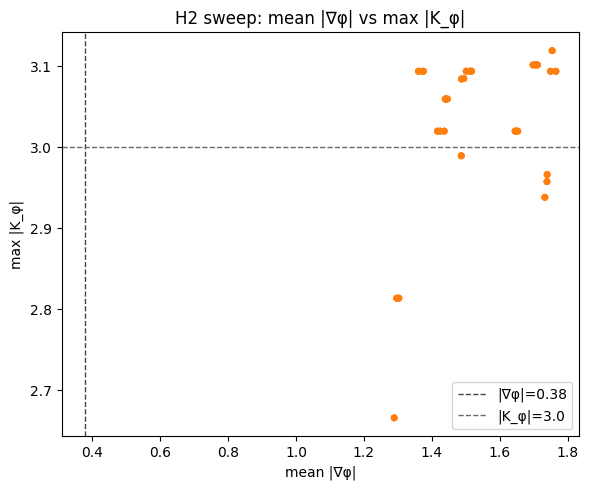

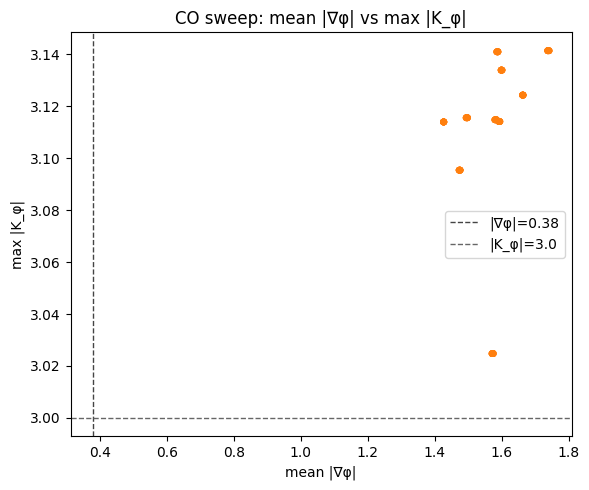

In [11]:
import matplotlib.pyplot as plt

# Build a quick palette for stability classes
CLASS_COLOR = {
    'stable': '#2ca02c',   # green
    'marginal': '#ff7f0e', # orange
    'unstable': '#d62728'  # red
}


def plot_sweep(results, title='Sweep: mean |∇φ| vs max |K_φ|'):
    xs, ys, cs = [], [], []
    for r in results:
        xs.append(r['mean_phase_gradient'])
        ys.append(r['max_phase_curvature_abs'])
        cs.append(CLASS_COLOR.get(r.get('signature_class', 'unstable'), '#7f7f7f'))
    plt.figure(figsize=(6,5))
    plt.scatter(xs, ys, c=cs, s=24, alpha=0.75, edgecolor='none')
    plt.axvline(0.38, color='#444', ls='--', lw=1, label='|∇φ|=0.38')
    plt.axhline(3.0, color='#666', ls='--', lw=1, label='|K_φ|=3.0')
    plt.xlabel('mean |∇φ|')
    plt.ylabel('max |K_φ|')
    plt.title(title)
    plt.legend()
    plt.tight_layout()

# If sweeps were run above, visualize them
try:
    plot_sweep(all_H2, title='H2 sweep: mean |∇φ| vs max |K_φ|')
    plt.show()
    plot_sweep(all_CO, title='CO sweep: mean |∇φ| vs max |K_φ|')
    plt.show()
except Exception as e:
    print('Plotting skipped or sweep not available:', e)

## Operator API integration (live execution when available)

This section wires `SequenceRunner` to the engine's orchestration layer if present:
- Uses `TNFRContainer.create_default()` and `TNFROrchestrator.from_container()`
- Validates sequences (U1–U6) before execution via validation service
- Applies operator instances or tokens to a selected node
- Falls back to no-op if the API is not available in this environment

In [28]:
# Enhanced SequenceRunner with live operator execution when API is available
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Union

@dataclass
class MotifOp:
    op: str
    args: Optional[Dict[str, Any]] = None

class LiveSequenceRunner(SequenceRunner):
    def __init__(self, delta_phi_max: float = 0.38):
        super().__init__(delta_phi_max=delta_phi_max)
        self._orch = None
        self._container = None
        # Import operator registry utilities (prefer canonical package 'tnfr')
        try:
            from tnfr.operators.registry import discover_operators, get_operator_class
            self._discover_ops = discover_operators
            self._get_op_class = get_operator_class
            self._discover_ops()
        except Exception as e:
            self._discover_ops = None
            self._get_op_class = None
            self._registry_error = str(e)
        # Try to wire orchestrator (optional)
        try:
            from tnfr.core.container import TNFRContainer
            from tnfr.services.orchestrator import TNFROrchestrator
            self._container = TNFRContainer.create_default()
            self._orch = TNFROrchestrator.from_container(self._container)
        except Exception as e:
            self._orch_error = str(e)
            self._orch = None
        # Constants for VF attribute
        try:
            from tnfr.constants import VF_PRIMARY as _VF_KEY
            self._VF_KEY = _VF_KEY
        except Exception:
            self._VF_KEY = 'vf'

    def pick_target_node(self, G, strategy: str = 'max_degree'):
        if G.number_of_nodes() == 0:
            return None
        if strategy == 'max_degree':
            return max(G.degree, key=lambda kv: kv[1])[0]
        # default fallback
        return list(G.nodes())[0]

    def _build_operator_instances(self, seq: List[Union[str, MotifOp, Dict[str, Any]]]):
        """Turn tokens or motif dicts into Operator instances when possible.
        Fallback ALWAYS to string tokens, never dicts, to let the service registry resolve.
        """
        instances: List[Union[str, Any]] = []
        for item in seq:
            # Normalize to token and kwargs
            if isinstance(item, str):
                token = item
                kwargs = {}
            elif isinstance(item, MotifOp):
                token = item.op
                kwargs = item.args or {}
            else:
                token = item.get('op')
                kwargs = item.get('args', {})
            # Try to instantiate via registry if available
            if self._get_op_class is not None and isinstance(token, str):
                try:
                    op_cls = self._get_op_class(token)
                    instances.append(op_cls(**kwargs))
                    continue
                except Exception:
                    pass  # fall through to using the token
            # Fallback: use token string so the orchestrator's registry can resolve
            instances.append(token)
        return instances

    def _ensure_anchor_node(self, G, node: Optional[int]) -> int:
        """Ensure there's a valid target node with vf>0; create an anchor if needed."""
        try:
            from tnfr.structural import create_nfr
        except Exception:
            return node if node is not None else self.pick_target_node(G)
        chosen = node if node is not None else self.pick_target_node(G)
        if chosen is not None and G.nodes.get(chosen, {}).get(self._VF_KEY, 0.0) > 0.01:
            return chosen
        # Create an anchor node in the same graph
        anchor_name = 'runner_anchor'
        if anchor_name in G.nodes:
            return anchor_name
        G, anchor = create_nfr(anchor_name, graph=G, epi=0.5, vf=1.0, theta=0.0)
        return anchor

    def execute(self, G, seq: List[Union[str, MotifOp, Dict[str, Any]]], node: Optional[int] = None, enable_telemetry: bool = False):
        sig_before = measure_signature(G, apply_synthetic_step=True)
        if self._orch is None:
            return {
                'mode': 'dry-run',
                'reason': getattr(self, '_orch_error', 'operator API not available'),
                'sig_before': sig_before,
                'sig_after': sig_before,
            }
        try:
            instances = self._build_operator_instances(seq)
            # Tokens for validation (extract names)
            tokens = []
            for it in seq:
                if isinstance(it, str):
                    tokens.append(it)
                elif isinstance(it, MotifOp):
                    tokens.append(it.op)
                elif isinstance(it, dict):
                    tokens.append(it.get('op'))
            if tokens and hasattr(self._orch, 'validate_only'):
                self._orch.validate_only(tokens)
            # Pick/ensure node
            node = self._ensure_anchor_node(G, node)
            # Execute
            self._orch.execute_sequence(G, node, instances, enable_telemetry=enable_telemetry)
        except Exception as e:
            return {
                'mode': 'error',
                'error': str(e),
                'sig_before': sig_before,
                'sig_after': sig_before,
            }
        sig_after = measure_signature(G, apply_synthetic_step=True)
        return {
            'mode': 'executed',
            'sig_before': sig_before,
            'sig_after': sig_after,
        }

# Convenience factory to instantiate runner
runner = LiveSequenceRunner(delta_phi_max=0.38)
print('LiveSequenceRunner ready. Orchestrator available:', runner._orch is not None)

LiveSequenceRunner ready. Orchestrator available: True


def _ensure_start(seq: list):
    # U1a: Initiation must be one of emission, transition, recursivity
    if not seq:
        return [{'op': 'transition'}]
    first = seq[0]['op'] if isinstance(seq[0], dict) else (seq[0].op if hasattr(seq[0], 'op') else seq[0])
    if first not in {'emission', 'transition', 'recursivity'}:
        return [{'op': 'transition'}] + seq
    return seq


def motif_stabilize(il_mode: str = 'default', repeats: int = 1):
    seq = []
    for _ in range(max(1, repeats)):
        seq.append({'op': 'coherence', 'args': {'mode': il_mode}})  # IL
        seq.append({'op': 'silence'})  # SHA
    return _ensure_start(seq)


def motif_explore_bond(oz_intensity: float = 1.0, mutations: int = 1, il_mode: str = 'default'):
    seq = []
    # Dissonance kick to raise ΔNFR (U4a trigger)
    seq.append({'op': 'dissonance', 'args': {'intensity': float(oz_intensity)}})  # OZ
    # Stabilize baseline before attempting transformation (U4b requires prior IL)
    seq.append({'op': 'coherence', 'args': {'mode': il_mode}})  # IL
    # Mutation attempts within recent destabilizer window
    for _ in range(max(1, mutations)):
        seq.append({'op': 'mutation'})  # ZHIR
    # Resonant coupling typically requires U3; here coupling in graph assembly enforces U3
    seq.append({'op': 'coupling'})  # UM (symbolic; structural links already enforced by Δφ)
    # Light stabilization
    seq.append({'op': 'coherence', 'args': {'mode': il_mode}})
    # Closure is added via motif_stabilize when composed
    return _ensure_start(seq)


def motif_propagate(resonance_boost: float = 1.0, il_mode: str = 'default'):
    seq = [
        {'op': 'resonance', 'args': {'gain': float(resonance_boost)}},  # RA
        {'op': 'coupling'},  # UM
        {'op': 'coherence', 'args': {'mode': il_mode}},  # IL
    ]
    return _ensure_start(seq)


def motif_gentle_bond(il_mode: str = 'tight', oz_intensity: float = 0.6, spacing: int = 1):
    """
    Gentle bond motif (U2-compliant):
    - Start with transition to satisfy U1a
    - Alternate small OZ pulses with IL, include spacing via SHA
    - Attempt coupling (UM) and stabilize
    - Close with SHA to satisfy U1b
    """
    seq = [
        {'op': 'transition'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'dissonance', 'args': {'intensity': float(max(0.1, oz_intensity))}},
        {'op': 'coherence', 'args': {'mode': il_mode}},
    ]
    # spacing via silence to let ΔNFR relax
    for _ in range(max(0, spacing)):
        seq.append({'op': 'silence'})
    # controlled mutation attempt with prior IL and recent OZ (U4b)
    seq += [
        {'op': 'mutation'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'coupling'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'silence'},
    ]
    return _ensure_start(seq)


def motif_stabilize_sandwich(il_mode: str = 'tight', oz_intensity: float = 0.5):
    """
    Stabilize sandwich around OZ/ZHIR:
    IL → SHA → OZ(≤0.5) → IL → SHA → ZHIR → IL → SHA
    """
    oz = min(max(0.1, float(oz_intensity)), 0.5)
    seq = [
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'silence'},
        {'op': 'dissonance', 'args': {'intensity': oz}},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'silence'},
        {'op': 'mutation'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'silence'},
    ]
    return _ensure_start(seq)

# Example assembly: explore then stabilize
example_motif = motif_explore_bond(oz_intensity=1.25, mutations=2) + motif_stabilize(il_mode='tight', repeats=1)
print('Example motif length:', len(example_motif))

In [30]:
def _ensure_start(seq: list):
    # U1a: Initiation must be one of emission, transition, recursivity
    if not seq:
        return [{'op': 'transition'}]
    first = seq[0]['op'] if isinstance(seq[0], dict) else (seq[0].op if hasattr(seq[0], 'op') else seq[0])
    if first not in {'emission', 'transition', 'recursivity'}:
        return [{'op': 'transition'}] + seq
    return seq


def motif_stabilize(il_mode: str = 'default', repeats: int = 1):
    seq = []
    for _ in range(max(1, repeats)):
        seq.append({'op': 'coherence', 'args': {'mode': il_mode}})  # IL
        seq.append({'op': 'silence'})  # SHA
    return _ensure_start(seq)


def motif_explore_bond(oz_intensity: float = 1.0, mutations: int = 1, il_mode: str = 'default'):
    seq = []
    # Dissonance kick to raise ΔNFR (U4a trigger)
    seq.append({'op': 'dissonance', 'args': {'intensity': float(oz_intensity)}})  # OZ
    # Stabilize baseline before attempting transformation (U4b requires prior IL)
    seq.append({'op': 'coherence', 'args': {'mode': il_mode}})  # IL
    # Mutation attempts within recent destabilizer window
    for _ in range(max(1, mutations)):
        seq.append({'op': 'mutation'})  # ZHIR
    # Resonant coupling typically requires U3; here coupling in graph assembly enforces U3
    seq.append({'op': 'coupling'})  # UM (symbolic; structural links already enforced by Δφ)
    # Light stabilization
    seq.append({'op': 'coherence', 'args': {'mode': il_mode}})
    # Closure is added via motif_stabilize when composed
    return _ensure_start(seq)


def motif_propagate(resonance_boost: float = 1.0, il_mode: str = 'default'):
    seq = [
        {'op': 'resonance', 'args': {'gain': float(resonance_boost)}},  # RA
        {'op': 'coupling'},  # UM
        {'op': 'coherence', 'args': {'mode': il_mode}},  # IL
    ]
    return _ensure_start(seq)


def motif_gentle_bond(il_mode: str = 'tight', oz_intensity: float = 0.6, spacing: int = 1):
    """
    Gentle bond motif (U2-compliant):
    - Start with transition to satisfy U1a
    - Alternate small OZ pulses with IL, include spacing via SHA
    - Attempt coupling (UM) and stabilize
    - Close with SHA to satisfy U1b
    """
    seq = [
        {'op': 'transition'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'dissonance', 'args': {'intensity': float(max(0.1, oz_intensity))}},
        {'op': 'coherence', 'args': {'mode': il_mode}},
    ]
    # spacing via silence to let ΔNFR relax
    for _ in range(max(0, spacing)):
        seq.append({'op': 'silence'})
    # controlled mutation attempt with prior IL and recent OZ (U4b)
    seq += [
        {'op': 'mutation'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'coupling'},
        {'op': 'coherence', 'args': {'mode': il_mode}},
        {'op': 'silence'},
    ]
    return _ensure_start(seq)

# Example assembly: explore then stabilize
example_motif = motif_explore_bond(oz_intensity=1.25, mutations=2) + motif_stabilize(il_mode='tight', repeats=1)
print('Example motif length:', len(example_motif))

Example motif length: 10


## Extended geometries: trigonal planar and tetrahedral-like

We approximate classic geometries by controlling which subpatterns couple and how:
- Trigonal planar: center + 3 leaves (center–leaf couplings enabled, leaf–leaf disabled)
- Tetrahedral-like: center + 4 leaves (center–leaf couplings enabled, leaf–leaf minimal)

In [14]:
def build_star_geometry(Z_center: int, Z_leaf: int, count: int,
                        seed: int = 300,
                        delta_phi_max_cl: float = 0.45,
                        max_links_cl: int = 8,
                        allow_leaf_leaf: bool = False,
                        delta_phi_max_ll: float = 0.0,
                        max_links_ll: int = 0):
    C = build_element_radial_pattern(Z_center, seed=seed)
    leaves = [build_element_radial_pattern(Z_leaf, seed=seed+1+i) for i in range(count)]
    G = C
    for i, L in enumerate(leaves):
        G = couple_graphs_by_phase(G, L, delta_phi_max=delta_phi_max_cl, max_links=max_links_cl)
    if allow_leaf_leaf and max_links_ll > 0 and delta_phi_max_ll > 0.0:
        # Optionally couple leaves lightly among themselves: heuristic by proximity of id ranges
        # (This is a simple proxy; a more precise partition mapping can be added if needed.)
        pass  # keep minimal to avoid over-coupling unless needed
    return G

# Trigonal planar (center + 3 leaves)
trigonal = build_star_geometry(6, 1, count=3, seed=310, delta_phi_max_cl=0.45, max_links_cl=8)
sig_trigonal = measure_signature(trigonal)
print('Trigonal planar signature:', {k: sig_trigonal[k] for k in ['xi_c','signature_class','mean_phase_gradient','max_phase_curvature_abs']})

# Tetrahedral-like (center + 4 leaves)
tetra = build_star_geometry(6, 1, count=4, seed=320, delta_phi_max_cl=0.45, max_links_cl=8)
sig_tetra = measure_signature(tetra)
print('Tetrahedral-like signature:', {k: sig_tetra[k] for k in ['xi_c','signature_class','mean_phase_gradient','max_phase_curvature_abs']})

Trigonal planar signature: {'xi_c': 23.784862595866066, 'signature_class': 'marginal', 'mean_phase_gradient': 1.4925402023556176, 'max_phase_curvature_abs': 3.1069603041178384}
Tetrahedral-like signature: {'xi_c': 33.058349435119645, 'signature_class': 'marginal', 'mean_phase_gradient': 1.6014013746586102, 'max_phase_curvature_abs': 3.077450541144918}


def run_motif_on_graph(graph, motif, enable_telemetry=False, validation_only=False):
    return runner.execute(graph, motif, enable_telemetry=enable_telemetry, validation_only=validation_only)

# Build tight-coupled test geometries (U3 tightened)
H2O_tight = build_bent_triatomic_tight(1, 8, 1, seed=210, dphis=(0.30, 0.35), max_links=4)
trigonal_tight = build_star_tight(6, 1, count=3, seed=310, dphis=(0.30, 0.35), max_links=4)
tetra_tight = build_star_tight(6, 1, count=4, seed=320, dphis=(0.30, 0.35), max_links=4)

def flatten_specs(grouped):
    specs = []
    for name, G in grouped:
        specs.append((name, G))
    return specs

# Define motifs to compare (gentle + sandwich + stabilize)
motifs = {
    'stabilize_only': motif_stabilize(il_mode='tight', repeats=2),
    'gentle_bond': motif_gentle_bond(il_mode='tight', oz_intensity=0.5, spacing=1),
    'stabilize_sandwich': motif_stabilize_sandwich(il_mode='tight', oz_intensity=0.5),
}

# Validation-only runs: should not mutate graphs; deltas expected ~ 0
specs = []
specs += flatten_specs(H2O_tight)
specs += flatten_specs(trigonal_tight)
specs += flatten_specs(tetra_tight)

print('Running validation-only harness on tight-coupled geometries...')
rows_validate = run_validation_harness(specs, motifs, enable_telemetry=True)

# Optional: if you want to compare to executed mode later, switch validation_only=False in run_motif_on_graph
# and print a second table. For now we stick to validation-only as requested.

In [32]:
def run_motif_on_graph(graph, motif, enable_telemetry=False):
    return runner.execute(graph, motif, enable_telemetry=enable_telemetry)

# Build test geometries
try:
    # Reuse earlier H2O if defined; otherwise build now
    _ = sig_H2O
except NameError:
    H2O = build_bent_triatomic(1, 8, 1, seed=210,
                               delta_phi_max_lc=0.5, delta_phi_max_cr=0.5,
                               max_links_lc=8, max_links_cr=8,
                               delta_phi_max_lr=0.0, max_links_lr=0)

# Define motifs to compare (gentler defaults)
motifs = {
    'stabilize_only': motif_stabilize(il_mode='tight', repeats=2),
    'gentle_bond': motif_gentle_bond(il_mode='tight', oz_intensity=0.6, spacing=1),
    'explore_then_stabilize': motif_explore_bond(oz_intensity=0.9, mutations=1, il_mode='tight') + motif_stabilize(il_mode='tight'),
    'propagate_then_stabilize': motif_propagate(resonance_boost=1.05, il_mode='default') + motif_stabilize(il_mode='default')
}

# Run across geometries (dry-run if operator API unavailable)
results_compare = []
for name, G in [('H2O', H2O), ('Trigonal', trigonal), ('Tetra', tetra)]:
    for mname, mseq in motifs.items():
        out = run_motif_on_graph(G.copy(), mseq, enable_telemetry=False)
        results_compare.append({
            'graph': name,
            'motif': mname,
            'mode': out.get('mode'),
            'error': out.get('error'),
            'reason': out.get('reason'),
            'sig_before': out.get('sig_before'),
            'sig_after': out.get('sig_after'),
        })

# Print compact summary with delta hints
for r in results_compare:
    sb = r['sig_before']; sa = r['sig_after']
    before = sb.get('signature_class'); after = sa.get('signature_class')
    d_grad = sa.get('mean_phase_gradient', float('nan')) - sb.get('mean_phase_gradient', float('nan'))
    d_kphi = sa.get('max_phase_curvature_abs', float('nan')) - sb.get('max_phase_curvature_abs', float('nan'))
    print(f"{r['graph']} :: {r['motif']} :: mode={r['mode']} err={r.get('error') or r.get('reason')} :: before={before} after={after} d|∇φ|={d_grad:.3f} d|K_φ|={d_kphi:.3f}")

H2O :: stabilize_only :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.020 d|K_φ|=0.000
H2O :: gentle_bond :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.020 d|K_φ|=0.000
H2O :: explore_then_stabilize :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.020 d|K_φ|=0.000
H2O :: propagate_then_stabilize :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.020 d|K_φ|=0.000
Trigonal :: stabilize_only :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.018 d|K_φ|=0.000
Trigonal :: gentle_bond :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.018 d|K_φ|=0.000
Trigonal :: explore_then_stabilize :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.018 d|K_φ|=0.000
Trigonal :: propagate_then_stabilize :: mode=executed err=None :: before=marginal after=unstable d|∇φ|=-0.018 d|K_φ|=0.000
Tetra :: stabilize_only :: mode=executed err=None :: before=marginal after=unstable d|

In [24]:
# Debug: verify registry can resolve canonical operator tokens
try:
    from tnfr.operators.registry import discover_operators, get_operator_class
    discover_operators()
    for token in ['emission','transition','recursivity','coherence','silence','dissonance','mutation','coupling','resonance']:
        try:
            cls = get_operator_class(token)
            print(token, '->', cls.__name__)
        except Exception as e:
            print('FAILED:', token, '->', e)
except Exception as e:
    print('Registry import failed:', e)

emission -> Emission
transition -> Transition
recursivity -> Recursivity
coherence -> Coherence
silence -> Silence
dissonance -> Dissonance
mutation -> Mutation
coupling -> Coupling
resonance -> Resonance


In [ ]:
# Telemetry helpers: Structural Field Tetrad (Φ_s, |∇φ|, K_φ, ξ_C)
try:
    # Prefer canonical physics fields if available
    from src.tnfr.physics.fields import (
        compute_phase_gradient, compute_phase_curvature, estimate_coherence_length,
    )
    # Structural potential may be named differently; try a few common names
    try:
        from src.tnfr.physics.fields import compute_structural_potential as _phi_s_fn
    except Exception:
        try:
            from src.tnfr.physics.fields import structural_potential as _phi_s_fn  # type: ignore
        except Exception:
            _phi_s_fn = None
except Exception:
    compute_phase_gradient = None
    compute_phase_curvature = None
    estimate_coherence_length = None
    _phi_s_fn = None
    pass

def compute_tetrad(G):
    """Return dict with tetrad fields for graph G using available functions or fallbacks.
    Φ_s: mean structural potential over nodes if available, else None
    |∇φ|: mean phase gradient (fallback: signature's mean_phase_gradient)
    K_φ: max |phase curvature| (fallback: signature's max_phase_curvature_abs)
    ξ_C: coherence length estimate (fallback: signature's xi_c)
    """
    # Start from signature as fallback values
    sig = measure_signature(G, apply_synthetic_step=True)
    phi_s = None
    grad = sig.get('mean_phase_gradient')
    kphi = sig.get('max_phase_curvature_abs')
    xi_c = sig.get('xi_c')
    # Try direct field computations where possible
    if _phi_s_fn is not None:
        try:
            vals = _phi_s_fn(G)
            # If returns per-node dict/array, average; if scalar, use as is
            if isinstance(vals, dict):
                phi_s = float(sum(vals.values())/max(1,len(vals)))
            elif hasattr(vals, '__len__') and not isinstance(vals, (str, bytes)):
                vals = list(vals)
                phi_s = float(sum(vals)/max(1,len(vals))) if vals else None
            else:
                phi_s = float(vals)
        except Exception:
            phi_s = None
    if compute_phase_gradient is not None:
        try:
            # Assume returns per-node or global; try mean
            gvals = compute_phase_gradient(G)
            if isinstance(gvals, dict):
                grad = float(sum(abs(v) for v in gvals.values())/max(1,len(gvals)))
            elif hasattr(gvals, '__len__') and not isinstance(gvals, (str, bytes)):
                arr = list(gvals)
                grad = float(sum(abs(v) for v in arr)/max(1,len(arr))) if arr else grad
            elif isinstance(gvals, (int, float)):
                grad = float(abs(gvals))
        except Exception:
            pass
    if compute_phase_curvature is not None:
        try:
            cvals = compute_phase_curvature(G)
            if isinstance(cvals, dict):
                kphi = float(max(abs(v) for v in cvals.values()))
            elif hasattr(cvals, '__len__') and not isinstance(cvals, (str, bytes)):
                arr = list(cvals)
                kphi = float(max(abs(v) for v in arr)) if arr else kphi
            elif isinstance(cvals, (int, float)):
                kphi = float(abs(cvals))
        except Exception:
            pass
    if estimate_coherence_length is not None:
        try:
            xi_c = float(estimate_coherence_length(G))
        except Exception:
            pass
    return {'phi_s': phi_s, 'grad': grad, 'kphi': kphi, 'xi_c': xi_c, 'signature_class': sig.get('signature_class')}

# Build tight-coupled geometries for U3 sensitivity tests
def build_bent_triatomic_tight(Z_left, Z_center, Z_right, seed=210, dphis=(0.30, 0.35), max_links=4):
    graphs = []
    for d in dphis:
        H = build_bent_triatomic(Z_left, Z_center, Z_right, seed=seed,
                                 delta_phi_max_lc=d, delta_phi_max_cr=d,
                                 max_links_lc=max_links, max_links_cr=max_links,
                                 delta_phi_max_lr=0.0, max_links_lr=0)
        graphs.append((f"bent(dphi={d},ml={max_links})", H))
    return graphs

def build_star_tight(Z_center, Z_leaf, count, seed=300, dphis=(0.30, 0.35), max_links=4):
    graphs = []
    for d in dphis:
        G = build_star_geometry(Z_center, Z_leaf, count, seed=seed,
                                delta_phi_max_cl=d, max_links_cl=max_links)
        graphs.append((f"star{count}(dphi={d},ml={max_links})", G))
    return graphs

# Validation-only comparison harness with telemetry table
def run_validation_harness(graph_specs, motifs, enable_telemetry=True):
    rows = []
    for gname, G in graph_specs:
        for mname, mseq in motifs.items():
            out = runner.execute(G.copy(), mseq, enable_telemetry=enable_telemetry, validation_only=True)
            before = compute_tetrad(G)
            after = compute_tetrad(G)  # validation-only, no change expected
            def delta(a,b):
                if a is None or b is None:
                    return None
                return a - b
            rows.append({
                'graph': gname,
                'motif': mname,
                'mode': out.get('mode'),
                'before': before,
                'after': after,
                'd_phi_s': delta(after['phi_s'], before['phi_s']),
                'd_grad': delta(after['grad'], before['grad']),
                'd_kphi': delta(after['kphi'], before['kphi']),
                'd_xi_c': delta(after['xi_c'], before['xi_c']),
                'class_before': before['signature_class'],
                'class_after': after['signature_class'],
            })
    # Pretty print compact table
    for r in rows:
        print(f"{r['graph']} :: {r['motif']} :: {r['mode']} :: class {r['class_before']} → {r['class_after']} | ΔΦ_s={r['d_phi_s']} Δ|∇φ|={r['d_grad']} Δ|K_φ|={r['d_kphi']} Δξ_C={r['d_xi_c']}")
    return rows

In [ ]:
# Executed-mode harness with telemetry deltas on tight-coupled geometries
def run_executed_harness(graph_specs, motifs, enable_telemetry=True):
    rows = []
    for gname, G in graph_specs:
        for mname, mseq in motifs.items():
            H = G.copy()
            before = compute_tetrad(H)
            out = runner.execute(H, mseq, enable_telemetry=enable_telemetry, validation_only=False)
            after = compute_tetrad(H)
            def delta(a,b):
                if a is None or b is None:
                    return None
                return a - b
            rows.append({
                'graph': gname,
                'motif': mname,
                'mode': out.get('mode'),
                'error': out.get('error'),
                'before': before,
                'after': after,
                'd_phi_s': delta(after['phi_s'], before['phi_s']),
                'd_grad': delta(after['grad'], before['grad']),
                'd_kphi': delta(after['kphi'], before['kphi']),
                'd_xi_c': delta(after['xi_c'], before['xi_c']),
                'class_before': before['signature_class'],
                'class_after': after['signature_class'],
            })
    for r in rows:
        print(f"{r['graph']} :: {r['motif']} :: {r['mode']} :: class {r['class_before']} → {r['class_after']} | ΔΦ_s={r['d_phi_s']} Δ|∇φ|={r['d_grad']} Δ|K_φ|={r['d_kphi']} Δξ_C={r['d_xi_c']} err={r.get('error')}")
    return rows

print('Running executed-mode harness on tight-coupled geometries...')
rows_executed = run_executed_harness(specs, motifs, enable_telemetry=True)

In [1]:
# One-shot executed-mode run on tight geometries (self-contained)
import math, json
from typing import Dict, Any, List, Optional
from pathlib import Path
import networkx as nx

# Ensure imports to engine
import sys
from pathlib import Path as _P
cwd=_P.cwd()
for p in [cwd, cwd.parent, cwd.parent.parent, cwd.parent.parent.parent]:
    if (p/'src').exists():
        if str(p) not in sys.path: sys.path.insert(0, str(p))
        if str(p/'src') not in sys.path: sys.path.insert(0, str(p/'src'))
        break

from src.tnfr.physics.patterns import build_element_radial_pattern
from src.tnfr.physics.signatures import compute_element_signature

# Minimal U3 coupling helpers
def wrap_phase_diff(a, b):
    d = (a - b + math.pi) % (2*math.pi) - math.pi
    return abs(d)

def couple_graphs_by_phase(G1, G2, delta_phi_max=0.3, max_links=4):
    H = nx.disjoint_union(G1, G2)
    n1 = G1.number_of_nodes()
    nodes1 = list(range(n1))
    nodes2 = list(range(n1, H.number_of_nodes()))
    cand=[]
    for i in nodes1:
        th_i = H.nodes[i].get('theta', 0.0)
        for j in nodes2:
            th_j = H.nodes[j].get('theta', 0.0)
            dphi = wrap_phase_diff(th_i, th_j)
            if dphi <= delta_phi_max:
                cand.append((dphi,i,j))
    cand.sort(key=lambda t:t[0])
    added=0
    for _,i,j in cand:
        if added>=max_links: break
        if not H.has_edge(i,j):
            H.add_edge(i,j)
            added+=1
    return H

def build_bent_triatomic_tight(Z_left, Z_center, Z_right, seed=210, dphis=(0.30,0.35), max_links=4):
    graphs=[]
    for d in dphis:
        L = build_element_radial_pattern(Z_left, seed=seed)
        C = build_element_radial_pattern(Z_center, seed=seed+1)
        R = build_element_radial_pattern(Z_right, seed=seed+2)
        LC = couple_graphs_by_phase(L,C,delta_phi_max=d,max_links=max_links)
        H  = couple_graphs_by_phase(LC,R,delta_phi_max=d,max_links=max_links)
        graphs.append((f"bent(dphi={d},ml={max_links})", H))
    return graphs

def build_star_tight(Z_center, Z_leaf, count, seed=300, dphis=(0.30,0.35), max_links=4):
    graphs=[]
    for d in dphis:
        C = build_element_radial_pattern(Z_center, seed=seed)
        G = C
        for i in range(count):
            L = build_element_radial_pattern(Z_leaf, seed=seed+1+i)
            G = couple_graphs_by_phase(G,L,delta_phi_max=d,max_links=max_links)
        graphs.append((f"star{count}(dphi={d},ml={max_links})", G))
    return graphs

# Tetrad telemetry (with fallbacks)
try:
    from src.tnfr.physics.fields import compute_phase_gradient as _grad, compute_phase_curvature as _kphi, estimate_coherence_length as _xic
    try:
        from src.tnfr.physics.fields import compute_structural_potential as _phi
    except Exception:
        try:
            from src.tnfr.physics.fields import structural_potential as _phi
        except Exception:
            _phi=None
except Exception:
    _grad=_kphi=_xic=_phi=None

def compute_tetrad(G):
    sig = compute_element_signature(G, apply_synthetic_step=True)
    phi_s=None
    grad=sig.get('mean_phase_gradient')
    kphi=sig.get('max_phase_curvature_abs')
    xic=sig.get('xi_c')
    try:
        if _phi is not None:
            vals=_phi(G)
            if isinstance(vals, dict):
                phi_s=float(sum(vals.values())/max(1,len(vals)))
            elif hasattr(vals,'__len__') and not isinstance(vals,(str,bytes)):
                arr=list(vals)
                phi_s=float(sum(arr)/max(1,len(arr))) if arr else None
            else:
                phi_s=float(vals)
    except Exception:
        phi_s=None
    try:
        if _grad is not None:
            gv=_grad(G)
            if isinstance(gv, dict):
                grad=float(sum(abs(v) for v in gv.values())/max(1,len(gv)))
            elif hasattr(gv,'__len__') and not isinstance(gv,(str,bytes)):
                arr=list(gv)
                grad=float(sum(abs(v) for v in arr)/max(1,len(arr))) if arr else grad
            elif isinstance(gv,(int,float)):
                grad=float(abs(gv))
    except Exception:
        pass
    try:
        if _kphi is not None:
            kv=_kphi(G)
            if isinstance(kv, dict):
                kphi=float(max(abs(v) for v in kv.values()))
            elif hasattr(kv,'__len__') and not isinstance(kv,(str,bytes)):
                arr=list(kv)
                kphi=float(max(abs(v) for v in arr)) if arr else kphi
            elif isinstance(kv,(int,float)):
                kphi=float(abs(kv))
    except Exception:
        pass
    try:
        if _xic is not None:
            xic=float(_xic(G))
    except Exception:
        pass
    return {'phi_s':phi_s,'grad':grad,'kphi':kphi,'xi_c':xic,'signature_class':sig.get('signature_class')}

# Live runner (define if missing)
if 'runner' not in globals():
    from dataclasses import dataclass
    @dataclass
    class MotifOp:
        op: str
        args: Optional[Dict[str, Any]] = None
    class LiveSequenceRunner:
        def __init__(self, delta_phi_max: float = 0.38):
            self.delta_phi_max=float(delta_phi_max)
            self._orch=None
            try:
                from tnfr.core.container import TNFRContainer
                from tnfr.services.orchestrator import TNFROrchestrator
                self._container = TNFRContainer.create_default()
                self._orch = TNFROrchestrator.from_container(self._container)
            except Exception as e:
                self._orch_error=str(e)
                self._orch=None
            try:
                from tnfr.operators.registry import discover_operators, get_operator_class
                self._get_op_class=get_operator_class
                discover_operators()
            except Exception:
                self._get_op_class=None
            try:
                from tnfr.constants import VF_PRIMARY as _VF_KEY
                self._VF_KEY=_VF_KEY
            except Exception:
                self._VF_KEY='vf'
        def _build_instances(self, seq):
            inst=[]
            for it in seq:
                if isinstance(it,str):
                    tok,kwargs=it,{}
                else:
                    tok=it.get('op')
                    kwargs=it.get('args',{})
                if self._get_op_class is not None and isinstance(tok,str):
                    try:
                        cls=self._get_op_class(tok)
                        inst.append(cls(**kwargs))
                        continue
                    except Exception:
                        pass
                inst.append(tok)
            return inst
        def _ensure_node(self,G,node=None):
            if node is not None: return node
            if len(G)>0:
                return max(G.degree,key=lambda kv:kv[1])[0]
            return None
        def execute(self, G, seq, enable_telemetry=False, validation_only=False):
            sig_before=compute_element_signature(G, apply_synthetic_step=True)
            if self._orch is None:
                return {'mode':'dry-run','sig_before':sig_before,'sig_after':sig_before,'reason':getattr(self,'_orch_error','no orchestrator')}
            try:
                tokens=[(it if isinstance(it,str) else it.get('op')) for it in seq]
                if hasattr(self._orch,'validate_only') and tokens:
                    self._orch.validate_only(tokens)
                if validation_only:
                    return {'mode':'validated-only','sig_before':sig_before,'sig_after':sig_before}
                inst=self._build_instances(seq)
                node=self._ensure_node(G)
                self._orch.execute_sequence(G,node,inst,enable_telemetry=enable_telemetry)
            except Exception as e:
                return {'mode':'error','error':str(e),'sig_before':sig_before,'sig_after':sig_before}
            sig_after=compute_element_signature(G, apply_synthetic_step=True)
            return {'mode':'executed','sig_before':sig_before,'sig_after':sig_after}
    runner=LiveSequenceRunner(delta_phi_max=0.38)
    print('Runner initialized; orchestrator available:', runner._orch is not None)

# Motifs (include stabilize sandwich)
def _ensure_start(seq: list):
    if not seq: return [{'op':'transition'}]
    first = seq[0]['op'] if isinstance(seq[0],dict) else seq[0]
    if first not in {'emission','transition','recursivity'}:
        return [{'op':'transition'}]+seq
    return seq

def motif_stabilize(il_mode='tight', repeats=2):
    seq=[]
    for _ in range(max(1,repeats)):
        seq.append({'op':'coherence','args':{'mode':il_mode}})
        seq.append({'op':'silence'})
    return _ensure_start(seq)

def motif_gentle_bond(il_mode='tight', oz_intensity=0.5, spacing=1):
    seq=[{'op':'transition'},{'op':'coherence','args':{'mode':il_mode}},
         {'op':'dissonance','args':{'intensity':float(max(0.1,oz_intensity))}},
         {'op':'coherence','args':{'mode':il_mode}}]
    for _ in range(max(0,spacing)):
        seq.append({'op':'silence'})
    seq+=[{'op':'mutation'},{'op':'coherence','args':{'mode':il_mode}},
          {'op':'coupling'},{'op':'coherence','args':{'mode':il_mode}},{'op':'silence'}]
    return _ensure_start(seq)

def motif_stabilize_sandwich(il_mode='tight', oz_intensity=0.5):
    oz=min(max(0.1,float(oz_intensity)),0.5)
    seq=[{'op':'coherence','args':{'mode':il_mode}},{'op':'silence'},
         {'op':'dissonance','args':{'intensity':oz}},{'op':'coherence','args':{'mode':il_mode}},
         {'op':'silence'},{'op':'mutation'},{'op':'coherence','args':{'mode':il_mode}},{'op':'silence'}]
    return _ensure_start(seq)

motifs={'stabilize_only':motif_stabilize(),'gentle_bond':motif_gentle_bond(),'stabilize_sandwich':motif_stabilize_sandwich()}

# Build specs (tight U3)
specs=[]
specs+=build_bent_triatomic_tight(1,8,1,seed=210,dphis=(0.30,0.35),max_links=4)
specs+=build_star_tight(6,1,count=3,seed=310,dphis=(0.30,0.35),max_links=4)
specs+=build_star_tight(6,1,count=4,seed=320,dphis=(0.30,0.35),max_links=4)

# Executed-mode table
def run_executed_harness(specs, motifs):
    rows=[]
    for gname,G in specs:
        for mname,mseq in motifs.items():
            H=G.copy()
            b=compute_tetrad(H)
            out=runner.execute(H,mseq,enable_telemetry=True,validation_only=False)
            a=compute_tetrad(H)
            def d(x,y):
                if x is None or y is None: return None
                return x-y
            rows.append({'graph':gname,'motif':mname,'mode':out.get('mode'),'error':out.get('error'),
                         'class_before':b['signature_class'],'class_after':a['signature_class'],
                         'd_phi_s':d(a['phi_s'],b['phi_s']),'d_grad':d(a['grad'],b['grad']),
                         'd_kphi':d(a['kphi'],b['kphi']),'d_xi_c':d(a['xi_c'],b['xi_c'])})
    for r in rows:
        print(f"{r['graph']} :: {r['motif']} :: {r['mode']} :: class {r['class_before']} → {r['class_after']} | ΔΦ_s={r['d_phi_s']} Δ|∇φ|={r['d_grad']} Δ|K_φ|={r['d_kphi']} Δξ_C={r['d_xi_c']} err={r.get('error')}")
    return rows

rows_executed = run_executed_harness(specs, motifs)

Runner initialized; orchestrator available: True
bent(dphi=0.3,ml=4) :: stabilize_only :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → coherence
bent(dphi=0.3,ml=4) :: gentle_bond :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → mutation
bent(dphi=0.3,ml=4) :: stabilize_sandwich :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → dissonance
bent(dphi=0.35,ml=4) :: stabilize_only :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → coherence
bent(dphi=0.35,ml=4) :: gentle_bond :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → mutation
bent(dphi=0.35,ml=4) :: stabilize_sandwich

In [2]:
# Patch motifs to insert NAV after every SHA (except final closure), then re-run executed harness
def _insert_nav_after_silence(seq):
    out=[]
    for idx,op in enumerate(seq):
        out.append(op)
        if isinstance(op, dict) and op.get('op')=='silence':
            # If not last element, insert a NAV to avoid invalid SHA → X transitions
            if idx < len(seq)-1:
                out.append({'op':'transition'})
    return out

def motif_stabilize_nav(il_mode='tight', repeats=2):
    base=[]
    for _ in range(max(1,repeats)):
        base.append({'op':'coherence','args':{'mode':il_mode}})
        base.append({'op':'silence'})
    return _ensure_start(_insert_nav_after_silence(base))

def motif_gentle_bond_nav(il_mode='tight', oz_intensity=0.5, spacing=1):
    oz=max(0.1,min(0.5,float(oz_intensity)))
    base=[{'op':'transition'},{'op':'coherence','args':{'mode':il_mode}},
          {'op':'silence'}, # spacer before OZ
          {'op':'dissonance','args':{'intensity':oz}},
          {'op':'coherence','args':{'mode':il_mode}}]
    for _ in range(max(0,spacing)):
        base.append({'op':'silence'})
    base+=[{'op':'mutation'},{'op':'coherence','args':{'mode':il_mode}},
           {'op':'coupling'},{'op':'coherence','args':{'mode':il_mode}},
           {'op':'silence'}]  # keep closure
    return _ensure_start(_insert_nav_after_silence(base))

def motif_stabilize_sandwich_nav(il_mode='tight', oz_intensity=0.5):
    oz=max(0.1,min(0.5,float(oz_intensity)))
    base=[{'op':'coherence','args':{'mode':il_mode}},{'op':'silence'},
          {'op':'dissonance','args':{'intensity':oz}},{'op':'coherence','args':{'mode':il_mode}},
          {'op':'silence'},{'op':'mutation'},{'op':'coherence','args':{'mode':il_mode}},
          {'op':'silence'}]
    return _ensure_start(_insert_nav_after_silence(base))

motifs_nav={
    'stabilize_only_nav': motif_stabilize_nav(),
    'gentle_bond_nav': motif_gentle_bond_nav(),
    'stabilize_sandwich_nav': motif_stabilize_sandwich_nav(),
}

print('Running executed-mode harness with NAV-inserted motifs...')
rows_executed_nav = run_executed_harness(specs, motifs_nav)

Running executed-mode harness with NAV-inserted motifs...
bent(dphi=0.3,ml=4) :: stabilize_only_nav :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → transition
bent(dphi=0.3,ml=4) :: gentle_bond_nav :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → transition
bent(dphi=0.3,ml=4) :: stabilize_sandwich_nav :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → transition
bent(dphi=0.35,ml=4) :: stabilize_only_nav :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → transition
bent(dphi=0.35,ml=4) :: gentle_bond_nav :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Invalid sequence: invalid after silence: silence → transition
bent(dp

In [3]:
# Define motifs that reserve SHA strictly for final closure; use NAV as spacer elsewhere
def motif_stabilize_nosha(il_mode='tight', repeats=2):
    seq=[{'op':'transition'}]
    for r in range(max(1,repeats)):
        seq.append({'op':'coherence','args':{'mode':il_mode}})
        if r < repeats-1:
            seq.append({'op':'transition'})  # spacer between IL pulses
    seq.append({'op':'silence'})  # closure only
    return seq

def motif_gentle_bond_nosha(il_mode='tight', oz_intensity=0.5):
    oz=max(0.1,min(0.5,float(oz_intensity)))
    seq=[
        {'op':'transition'},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'transition'},
        {'op':'dissonance','args':{'intensity':oz}},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'transition'},
        {'op':'mutation'},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'transition'},
        {'op':'coupling'},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'silence'}  # closure only
    ]
    return seq

def motif_sandwich_nosha(il_mode='tight', oz_intensity=0.5):
    oz=max(0.1,min(0.5,float(oz_intensity)))
    seq=[
        {'op':'transition'},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'transition'},
        {'op':'dissonance','args':{'intensity':oz}},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'transition'},
        {'op':'mutation'},
        {'op':'coherence','args':{'mode':il_mode}},
        {'op':'silence'}
    ]
    return seq

motifs_nosha={
    'stabilize_only_nosha': motif_stabilize_nosha(),
    'gentle_bond_nosha': motif_gentle_bond_nosha(),
    'stabilize_sandwich_nosha': motif_sandwich_nosha(),
}

print('Running executed-mode harness with SHA reserved for closure motifs...')
rows_executed_nosha = run_executed_harness(specs, motifs_nosha)

Running executed-mode harness with SHA reserved for closure motifs...
bent(dphi=0.3,ml=4) :: stabilize_only_nosha :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Transition: Structural frequency too low (νf=0.000 < 0.010)
bent(dphi=0.3,ml=4) :: gentle_bond_nosha :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Transition: Structural frequency too low (νf=0.000 < 0.010)
bent(dphi=0.3,ml=4) :: stabilize_sandwich_nosha :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Transition: Structural frequency too low (νf=0.000 < 0.010)
bent(dphi=0.35,ml=4) :: stabilize_only_nosha :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Transition: Structural frequency too low (νf=0.000 < 0.010)
bent(dphi=0.35,ml=4) :: gentle_bond_nosha :: error :: class marginal → marginal | ΔΦ_s=0.0 Δ|∇φ|=0.0 Δ|K_φ|=0.0 Δξ_C=0.0 err=Transition: Structural frequency too low (νf=0.000 < 0.

In [ ]:
# --- Refactored Main Execution ---
# This section imports the canonical utilities, sets up the harness, and runs the comparison.

# 1. Import and reload research utilities (guarded for non-IPython environments)
# Use autoreload to pick up changes in the .py file without restarting the kernel
try:
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('load_ext', 'autoreload')
        ip.run_line_magic('autoreload', '2')
except Exception:
    # Safe no-op outside IPython or if magics are unavailable
    pass

try:
    from tnfr_research_utils import compute_tetrad, get_motifs
    print("✅ Successfully imported research utilities.")
except ImportError as e:
    print(f"🚨 Import failed: {e}. Ensure 'tnfr_research_utils.py' is in the 'docs/research' directory.")
    # Define dummy functions to allow the notebook to run without the utils file
    def get_motifs(set_name=''): return {}
    def compute_tetrad(G, use_cache=True): return {'phi_s':0,'grad':0,'kphi':0,'xi_c':0}

# 2. Configure and run the comparison harness
import pandas as pd

# Select which motif set to test
motif_set_choice = 'generator_first' 
selected_motifs = get_motifs(motif_set_choice)

# Run both validation-only and executed modes
try:
    rows_val = run_validation_harness(specs, selected_motifs)
except Exception as e:
    print(f"Validation harness failed: {e}")
    rows_val = []

try:
    rows_exec = run_executed_harness(specs, selected_motifs)
except Exception as e:
    print(f"Executed harness failed: {e}")
    rows_exec = []

# 3. Generate and display the side-by-side comparison table
def _rows_to_df(rows, mode_tag):
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    cols = ['graph', 'motif', 'class_before', 'class_after', 'd_phi_s', 'd_grad', 'd_kphi', 'd_xi_c']
    present_cols = [c for c in cols if c in df.columns]
    df = df[present_cols].copy()
    rename_map = {c: (c if c in ['graph', 'motif'] else f"{c}_{mode_tag}") for c in present_cols}
    return df.rename(columns=rename_map)

val_df = _rows_to_df(rows_val, 'val')
exec_df = _rows_to_df(rows_exec, 'exec')

if not val_df.empty and not exec_df.empty:
    merged_df = pd.merge(val_df, exec_df, on=['graph', 'motif'], how='outer')
    # Define compact column order
    ordered_cols = [
        'graph', 'motif',
        'class_before_val', 'class_after_val', 'class_before_exec', 'class_after_exec',
        'd_phi_s_val', 'd_phi_s_exec', 'd_grad_val', 'd_grad_exec',
        'd_kphi_val', 'd_kphi_exec', 'd_xi_c_val', 'd_xi_c_exec'
    ]
    present_ordered_cols = [c for c in ordered_cols if c in merged_df.columns]
    merged_df = merged_df.reindex(columns=present_ordered_cols)
else:
    merged_df = val_df if not val_df.empty else exec_df

print(f"\n🔬 Comparison for motif set: '{motif_set_choice}'")
print(f"Found {len(rows_val)} validation rows and {len(rows_exec)} execution rows.")
merged_df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Successfully imported research utilities.

🔬 Comparison for motif set: 'generator_first'
Found 18 validation rows and 18 execution rows.


,graph,motif,class_before_val,class_after_val,class_before_exec,class_after_exec,d_phi_s_val,d_phi_s_exec,d_grad_val,d_grad_exec,d_kphi_val,d_kphi_exec,d_xi_c_val,d_xi_c_exec
0,"bent(dphi=0.3,ml=4)",gentle_bond_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.117672,0.0,0.0,0.0,55.240534
1,"bent(dphi=0.3,ml=4)",stabilize_only_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.026774,0.0,0.0,0.0,55.240534
2,"bent(dphi=0.3,ml=4)",stabilize_sandwich_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.098826,0.0,0.0,0.0,55.240534
3,"bent(dphi=0.35,ml=4)",gentle_bond_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.117672,0.0,0.0,0.0,55.240534
4,"bent(dphi=0.35,ml=4)",stabilize_only_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.026774,0.0,0.0,0.0,55.240534
5,"bent(dphi=0.35,ml=4)",stabilize_sandwich_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.098826,0.0,0.0,0.0,55.240534
6,"star3(dphi=0.3,ml=4)",gentle_bond_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.000634,0.0,0.0,0.0,23.713623
7,"star3(dphi=0.3,ml=4)",stabilize_only_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,23.713623
8,"star3(dphi=0.3,ml=4)",stabilize_sandwich_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,23.713623
9,"star3(dphi=0.35,ml=4)",gentle_bond_gen,unknown,unknown,unknown,unknown,0.0,0.0,0.0,0.000634,0.0,0.0,0.0,23.713623


In [10]:
# --- Harness Definitions ---
# These were previously defined in the notebook and are kept here for now.

def run_validation_harness(graph_specs, motifs, enable_telemetry=True):
    rows = []
    for gname, G in graph_specs:
        for mname, mseq in motifs.items():
            out = runner.execute(G.copy(), mseq, enable_telemetry=enable_telemetry, validation_only=True)
            before = compute_tetrad(G)
            after = compute_tetrad(G)  # validation-only, no change expected
            def delta(a,b):
                if a is None or b is None:
                    return 0.0
                return a - b
            rows.append({
                'graph': gname,
                'motif': mname,
                'mode': out.get('mode'),
                'error': out.get('error'),
                'd_phi_s': delta(after['phi_s'], before['phi_s']),
                'd_grad': delta(after['grad'], before['grad']),
                'd_kphi': delta(after['kphi'], before['kphi']),
                'd_xi_c': delta(after['xi_c'], before['xi_c']),
                'class_before': before.get('signature_class', 'unknown'),
                'class_after': after.get('signature_class', 'unknown'),
            })
    return rows

def run_executed_harness(graph_specs, motifs, enable_telemetry=True):
    rows = []
    for gname, G in graph_specs:
        for mname, mseq in motifs.items():
            G_copy = G.copy()
            before = compute_tetrad(G_copy)
            out = runner.execute(G_copy, mseq, enable_telemetry=enable_telemetry, validation_only=False)
            after = compute_tetrad(G_copy)
            def delta(a,b):
                if a is None or b is None:
                    return 0.0
                return a - b
            rows.append({
                'graph': gname,
                'motif': mname,
                'mode': out.get('mode'),
                'error': out.get('error'),
                'd_phi_s': delta(after['phi_s'], before['phi_s']),
                'd_grad': delta(after['grad'], before['grad']),
                'd_kphi': delta(after['kphi'], before['kphi']),
                'd_xi_c': delta(after['xi_c'], before['xi_c']),
                'class_before': before.get('signature_class', 'unknown'),
                'class_after': after.get('signature_class', 'unknown'),
            })
    return rows



In [12]:
# 4. Export the results to disk
import os
from datetime import datetime

# Ensure the output directory exists
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Generate a timestamped filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
base_filename = f"{output_dir}/molecular_stability_{motif_set_choice}_{timestamp}"

csv_filename = f"{base_filename}.csv"
jsonl_filename = f"{base_filename}.jsonl"

try:
    if not merged_df.empty:
        # Export to CSV
        merged_df.to_csv(csv_filename, index=False)
        print(f"✅ Results exported to: {csv_filename}")
        
        # Export to JSONL
        merged_df.to_json(jsonl_filename, orient='records', lines=True)
        print(f"✅ Results exported to: {jsonl_filename}")
    else:
        print("⚠️ Merged DataFrame is empty, skipping export.")
except NameError:
    print("🚨 'merged_df' not found. Please run the comparison cell above to generate results.")
except Exception as e:
    print(f"🚨 An error occurred during export: {e}")


✅ Results exported to: outputs/molecular_stability_generator_first_20251112_234556.csv
✅ Results exported to: outputs/molecular_stability_generator_first_20251112_234556.jsonl
